# Fischmarkt Spotify Analysis
This notebook explores the legendary fischmarkt mit der gang playlists created by the fischmarkt legends Freddy, Steffen and Henry.

To this date, there are six playlists:
- [v1](https://open.spotify.com/playlist/3hWJlo2emaZ3prlBcZNrSs?si=7TX9eROyT2GxIceX_l5ZDg)
- [v2](https://open.spotify.com/playlist/3bVBRlfXKvgUem33ZbGtHU?si=mbz0Q-2uQIWMdIBRQlgbJg)
- [v3](https://open.spotify.com/playlist/6uZ4P3JkWXqj1258Ub8vMH?si=6ZGeiIuLQUyBH6MoK8U9Wg)
- [v4](https://open.spotify.com/playlist/09Wqa8W5g2iGTXsK1MJPFC?si=NWo20lnFQdaUtk4MMAlbEg)
- [v5](https://open.spotify.com/playlist/5Vvc0zw608FfwWmXHjr6tb?si=ZWvtm2UuRCKZzY2aEKR6dA)
- [v6](https://open.spotify.com/playlist/4RHM7Kk3VtOljBhKdGym8B?si=ydSvyE_kTqmewCUV6EdvDA)

## Set env variables
First, the credentials for the spotify API have to be set to the env so that they can be accessed by the spotipy library.

In [1]:
import config
import os
os.environ["SPOTIPY_CLIENT_ID"] = config.spotify_credentials['id']
os.environ["SPOTIPY_CLIENT_SECRET"] = config.spotify_credentials['password']

## Import the required modules and set constants
Then the required modules are imported, and the user and playlist ID's are set.

In [2]:
import pandas as pd
import spotipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import string 
from spotipy.oauth2 import SpotifyClientCredentials
fischmarkt_uris =['spotify:playlist:3hWJlo2emaZ3prlBcZNrSs',
                  'spotify:playlist:3bVBRlfXKvgUem33ZbGtHU',
                  'spotify:playlist:6uZ4P3JkWXqj1258Ub8vMH',
                  'spotify:playlist:09Wqa8W5g2iGTXsK1MJPFC',
                  'spotify:playlist:5Vvc0zw608FfwWmXHjr6tb',
                  'spotify:playlist:4RHM7Kk3VtOljBhKdGym8B']
columns = ['added_at', 'track_name', 'track_id', 'artists', 'added_by', 'explicit', 'duration',  'album_name', 'album_id', 'release_date', 'V']
users = config.users

## Get playlist JSONs from spotify API


In [3]:
playlist_jsons = []
for uri in fischmarkt_uris:
    spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
    results = spotify.playlist(uri)
    playlist_jsons.append(results)

## Parse the JSONs to a panda Dataframe

In [4]:
playlist_dfs = []
counter = 0
for json in playlist_jsons:
    df = pd.DataFrame.from_dict(json['tracks']['items'])
    df['V'] = counter
    counter += 1
    playlist_dfs.append(df)

df = pd.concat(playlist_dfs, ignore_index=True)

## Rename columns, format values and drop unnecessary information
The columns still contain nested information and some columns such as 'primary color' are not needed. Therefore, the nested information is "unpacked" and columns that are not needed are dropped.

In [5]:
# unpack information
df['track_id'] = df['track'].apply(lambda x: x['id'])
df['track_name'] = df['track'].apply(lambda x: x['name'])
df['album_id'] = df['track'].apply(lambda x: x['album']['id'])
df['album_name'] = df['track'].apply(lambda x: x['album']['name'])
df['artists'] = df['track'].apply(lambda x: x['artists'])
df['added_by'] = df['added_by'].apply(lambda x: x['uri'])
df['explicit'] = df['track'].apply(lambda x: x['explicit'])
df['duration'] = df['track'].apply(lambda x: x['duration_ms'] / 1000)
df['release_date'] = df['track'].apply(lambda x: x['album']['release_date'])
df = df[columns]

# transform nested artist info into an array of artists
def artist_to_array(artists):
    artists_new = []
    for a in artists:
        artists_new.append([a['name'], a['id']])
    return artists_new

df['artists'] = df['artists'].apply(artist_to_array)

# set correct types of columns
df = df.astype({'release_date': 'datetime64[ns]', 'added_at': 'datetime64[ns]'})
df['age'] = (df['added_at'] - df['release_date']).dt.days
for u in users:
    df['added_by'] = df['added_by'].replace(u['id'], u['name'])
    
# rename columns to make names a bit _nicer_
column_name_dict = {'added_at': 'Date Added',
               'track_id': 'ID',
               'added_by': 'Gang Member'}

def nice_column_names(x):
    x = x.replace('_', ' ')
    x = string.capwords(x)
    return x

df.rename(columns=column_name_dict, inplace=True)
df.columns = list(map(nice_column_names, df.columns))
df

,Date Added,Track Name,Id,Artists,Gang Member,Explicit,Duration,Album Name,Album Id,Release Date,V,Age
0,2019-04-11 12:56:47,Messer,6Bqm2beg8uT0aEt8GM83LL,"[[Prinz Pi, 3OYM3jjPVR60kOqmamRRgk], [Bosse, 2...",Freddy,False,184.044,Messer,7uTSjA9bHLZ2GaYPeh56Cu,2019-03-12,0,30.0
1,2019-04-11 14:48:55,Ride With Me,3iYN00oie5yQc72NjDKFfJ,"[[Thutmose, 1igl9M102nuD96lo3ZoW5d]]",Steffen,True,182.686,Man On Fire Mixtape,4y0lpu374UzSpcTS2y1wCw,2018-10-24,0,169.0
2,2019-04-11 14:49:56,Paid In Full,1CFbMhxQjCT3OH3YLvBkNF,"[[SAFE, 3bnpcWBcvlfq4hPFJjNPbz], [Playboi Cart...",Steffen,True,202.080,Paid In Full,0to6F8xxZGgeFNMq7TEMpi,2019-04-05,0,6.0
3,2019-04-11 14:50:36,64 Kammern,221oPaI4JfsdkDPryeZWaT,"[[Olexesh, 2Z9KL8Zmqx5Sg3cd7Fldhl]]",Freddy,True,261.004,Makadam (Bonus Tracks Version),66OvSRoGZPWG4kh1wI1OuT,2016-10-21,0,902.0
4,2019-04-11 14:50:48,Money In The Way,1Du1gIiBziiR6SUx3gnSvr,"[[2 Chainz, 17lzZA2AlOHwCwFALHttmp]]",Freddy,True,161.653,Rap Or Go To The League,1BR69wIifGZUSimcuTjWVg,2019-03-01,0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-06-06 16:56:10,DAS RENNEN,3qT2eKpWNq5cze7kGGORDZ,"[[RIN, 18ISxWwWjV6rPLoVCXf1dz]]",Steffen,False,193.684,DAS RENNEN,38xCCfybcmBDFD1HVyHhSy,2020-06-05,5,1.0
361,2020-06-07 06:17:21,San Pellegrino,6kP5RwLme68mX5tt5HOmBx,"[[BHZ, 3mmI5HKArDwgggj4j0aJyC], [Monk, 0jEyGu5...",Freddy,True,217.371,3062,7gr2YbcnJF1g6IorxlZBpG,2019-09-13,5,268.0
362,2020-06-08 12:00:48,Seit du gesagt hast,3pZR2jLSPB7b9kFROuCxZ2,"[[Danger Dan, 2jXb8AWz82Sn3RRGOaia7a]]",Henry,False,206.451,Reflexionen aus dem beschönigten Leben,74CrIDwLDcI8HFvye6Vkht,2018-06-01,5,738.0
363,2020-06-08 20:07:34,Djadja,6FqqTni0AEtGXynpMpDm4L,"[[Aya Nakamura, 7IlRNXHjoOCgEAWN5qYksg]]",Freddy,False,171.133,NAKAMURA,1co4qjh6yQGXUnVM52yEYb,2018-11-02,5,584.0


# Analysis
In the following the data on the playlists is explored and analysed

### Current number of songs

In [6]:
len(df)

365

## By Gang Member
This section explores characteristics of the data by user ('memebers' 😉).

### Contributions by individual members.

In [7]:
%matplotlib inline
colors = ['#731DD8', '#48A9A6', '#F5Cb5C', '#FF9FB2']
shades = ['#2e0b56', '#501497', '#731dd8', '#9d60e3', '#c7a4ef', '#e3d1f7']
count_df = df.groupby('Gang Member').count()['Date Added'].reset_index()
plt.rcParams['figure.figsize'] = [10, 5]
sns.set()
sns.set_palette(sns.color_palette(colors))
count_df = df.groupby('Gang Member').count()['Date Added']
count_df.loc['Total'] = count_df.sum()
count_df

Gang Member
Freddy     116
Henry      144
Steffen    105
Total      365
Name: Date Added, dtype: int64

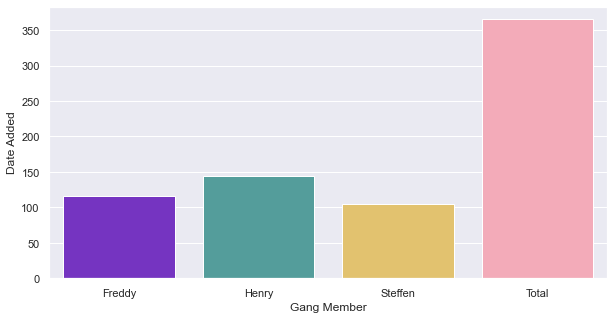

In [8]:
sns.barplot(x="Gang Member", y="Date Added", data=count_df.reset_index())

### Explicit Song Share by Gang Member
Share of songs that are marked as "explicit" by Spotify.

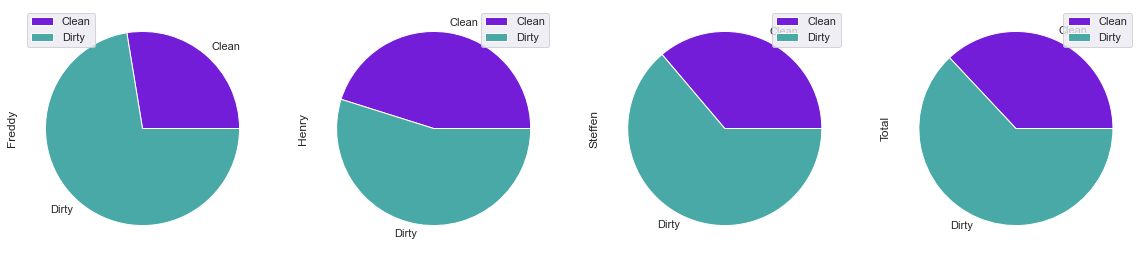

Explicit     Clean  Dirty  Share of Dirty Songs
Gang Member                                    
Freddy          32     84                 72.41
Henry           65     79                 54.86
Steffen         38     67                 63.81
Total          135    230                 63.01


In [9]:
explicit_df = df.groupby('Gang Member')['Explicit'].value_counts().unstack().fillna(0).rename(columns={False: 'Clean', True: 'Dirty'})
explicit_df.loc["Total"] = explicit_df.sum()
explicit_df.T.plot.pie(subplots=True, figsize=(20, 10))

# calculate share and round to 2 digits
explicit_df['Share of Dirty Songs'] = round((explicit_df['Dirty'] / (explicit_df['Clean'] + explicit_df['Dirty'])) * 100, 2)
plt.show()
print(explicit_df)

## Favorite Artists by Gang Member
How many songs by an artist were added to the playlists per member

In [10]:
a = {}
for index, row in df.iterrows():
    for artist in row['Artists']:
        gm = row['Gang Member']
        a_name = artist[0]
        if a_name in a:
            a[a_name]['Total'] += 1
            if gm in a[a_name]:
                a[a_name][gm] +=1
            else:
                a[a_name][gm] = 1
        else:
            a[a_name] = {'Total': 1, gm: 1}
artist_count = pd.DataFrame.from_dict(a).T

# print overall favorite artists
print('Overall Favorite Artists')
print(artist_count.sort_values(by=['Total'], ascending=False)['Total'].head(5))
print('%d different artists are on the fischmarkt lists\n \n' % (len(artist_count['Total'].dropna())))

# print favorite artists
for u in users:
    n = u['name']
    print('Favorite Artists of %s' %n)
    print(artist_count.sort_values(by=[n], ascending=False)[n].head(5))
    print('%s has added %d different artists \n \n' % (n, len(artist_count[n].dropna())))

Overall Favorite Artists
Haftbefehl    12.0
Trettmann     11.0
JAY-Z         11.0
Shindy        11.0
Bonez MC      10.0
Name: Total, dtype: float64
335 different artists are on the fischmarkt lists
 

Favorite Artists of Freddy
Olexesh    8.0
Tyga       6.0
Shindy     6.0
Drake      6.0
JAY-Z      5.0
Name: Freddy, dtype: float64
Freddy has added 156 different artists 
 

Favorite Artists of Henry
Bonez MC       8.0
RAF Camora     8.0
Trettmann      7.0
Haftbefehl     6.0
KitschKrieg    6.0
Name: Henry, dtype: float64
Henry has added 146 different artists 
 

Favorite Artists of Steffen
Haiyti       5.0
Kid Cudi     4.0
RIN          4.0
badchieff    4.0
Trettmann    3.0
Name: Steffen, dtype: float64
Steffen has added 117 different artists 
 



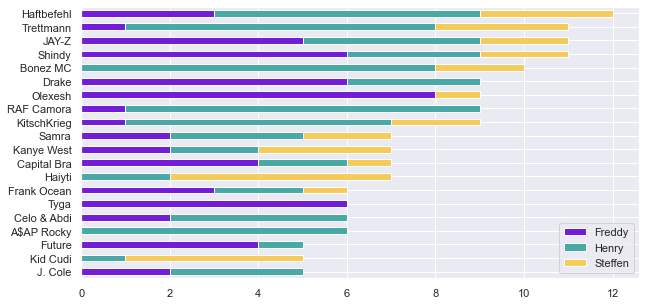

In [11]:
display_df = artist_count.sort_values('Total', ascending=False)
display_df.head(20).sort_values('Total').drop(columns=['Total']).plot(kind='barh', stacked=True)

## By Playlist Version
This section explores characteristics of by playlists.

### Days since release when Song is added to playlist

Text(0, 0.5, 'Average age of song when added to playlist (days)')

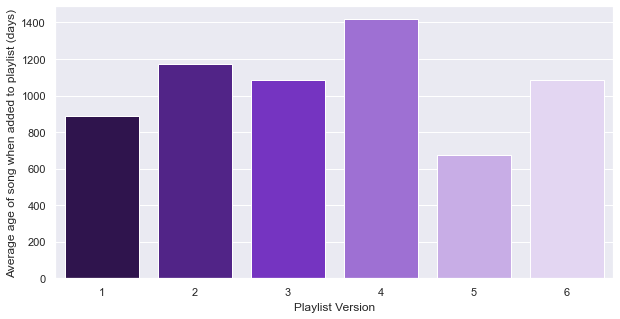

In [12]:
age_df = df.groupby(['V'])['Age'].mean().reset_index()
actual_version = age_df['V'] + 1
sns.barplot(x=actual_version, y='Age', data=age_df, palette=sns.color_palette(shades))
plt.xlabel("Playlist Version")
plt.ylabel("Average age of song when added to playlist (days)")